# IFPEN Data: Training models and and evaluation on test set for submission (Data Challenge) 
### Features are computed using the notebook Feature_IFPEN_Data

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
import pickle
import sklearn.metrics as met

from sklearn.preprocessing import LabelEncoder

from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, erosion, skeletonize_3d

%matplotlib inline

#Paths 
CHALLENGE_PATH = "C:/Chazal/ChallengeIFPEN2018/"
DATA_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Data/"
TOOLS_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Tools/"

#Some constants
DEFAULT_SIZE = [175,152,152]
NB_INPUT_IMG = 400

#Home made tools for persistence features
os.chdir("C:/Seafile/Ma bibliothèque/Chazal2/MyPython36") 
from DTM import *
#from persistent_surface import *
from PdiagFeatures import *

#Classes provided with the data 
os.chdir(TOOLS_PATH)
from Image3D import Image3D
from ImageIO import ImageIO

In [2]:
! pip install xgboost

In [12]:
import xgboost as xgb
xr = xgb.XGBRegressor()

In [258]:
#sklearn stuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix    
from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression, LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, SelectFromModel

In [14]:
#For 2D CNN experiments
import os,cv2

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

import keras

from keras import backend as K
K.set_image_dim_ordering('tf')

from keras.utils import np_utils
from keras.models import Sequential, Model
#from keras.layers.core import Dense, Dropout, Activation, Flatten, Merge, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.layers import Dense, Input, Dropout, Activation, Merge, BatchNormalization, Flatten
from keras import optimizers

### Functions to load the data and the output files

In [15]:
def load_outputs(output_path=CHALLENGE_PATH):
    csv_path = os.path.join(output_path,"challenge_fichier_de_sortie_dentrainement_prediction_de_la_saturation_dhuile_residuelle.csv")
    return pd.read_csv(csv_path,sep=';')

DEFAULT_SIZE = [175,152,152]

def load_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_img3D = []
    for nb in range(400):
        file_name = data_path + "input_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_img3D.append(img)
    return list_img3D

def load_output_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_out_img3D = []
    for nb in range(400):
        file_name = data_path + "output_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_out_img3D.append(img)
    return list_out_img3D

### Load input training data and labels

In [6]:
list_img3D = load_data()
outputs = load_outputs()

## 1. Load all computed features on training data

### Load all non persistent features

In [17]:
Feat_vol_voids = pickle.load(open(CHALLENGE_PATH + "Feat_vol_voids.dat", "rb"), encoding="latin1")
kNN=1
Feat_volDTM_voids = pickle.load(open(CHALLENGE_PATH + "Feat_volDTM"+ str(kNN) +"_voids.dat", "rb"), encoding="latin1")
Feat_area_bd = pickle.load(open(CHALLENGE_PATH + "Feat_area_bd.dat", "rb"), encoding="latin1")
Feat_vol_slices = pickle.load(open(CHALLENGE_PATH + "Voids_slices.dat", "rb"), encoding="latin1")
Feat_length_slices = pickle.load(open(CHALLENGE_PATH + "Length_slices.dat","rb"),encoding="latin1")
Feat_loc_max = pickle.load(open(CHALLENGE_PATH + "Feat_Locmax.dat", "rb"),encoding="latin1")
Feat_density_hist = pickle.load(open(CHALLENGE_PATH + "SetDensity2_hist.dat", "rb"),encoding="latin1")
Feat_skel = pickle.load(open(CHALLENGE_PATH + "Skeleton.dat", "rb"),encoding="latin1")
#Not saved but easy and fast to compute (from cells above):
# Feat_mat

### Load persistence images features

In [100]:
file_name_dgm = "Feat_DTM30_pers0.dat"
Feat_DTM30_pers0 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_DTM30_pers1.dat"
Feat_DTM30_pers1 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_DTM30_pers2.dat"
Feat_DTM30_pers2 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")

file_name_dgm = "Feat_DTM1_pers0.dat"
Feat_DTM1_pers0 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_DTM1_pers1.dat"
Feat_DTM1_pers1 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_DTM1_pers2.dat"
Feat_DTM1_pers2 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")

file_name_dgm = "Feat_locmax_pers0.dat"
Feat_locmax_pers0 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_locmax_pers1.dat"
Feat_locmax_pers1 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_locmax_pers2.dat"
Feat_locmax_pers2 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")

file_name_dgm = "Feat_locmax_dist_pers0.dat"
Feat_locmax_dist_pers0 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_locmax_dist_pers1.dat"
Feat_locmax_dist_pers1 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_locmax_dist_pers2.dat"
Feat_locmax_dist_pers2 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")

file_name_dgm = "Feat_SetIntensity2_pers0.dat"
Feat_SetIntensity2_pers0 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_SetIntensity2_pers1.dat"
Feat_SetIntensity2_pers1 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_SetIntensity2_pers2.dat"
Feat_SetIntensity2_pers2 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")

file_name_dgm = "Feat_hX_pers0.dat"
Feat_hX_pers0 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_hX_pers1.dat"
Feat_hX_pers1 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_hX_pers2.dat"
Feat_hX_pers2 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")

file_name_dgm = "Feat_hY_pers0.dat"
Feat_hY_pers0 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_hY_pers1.dat"
Feat_hY_pers1 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_hY_pers2.dat"
Feat_hY_pers2 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")

file_name_dgm = "Feat_hZ_pers0.dat"
Feat_hZ_pers0 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_hZ_pers1.dat"
Feat_hZ_pers1 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")
file_name_dgm = "Feat_hZ_pers2.dat"
Feat_hZ_pers2 = pickle.load(open(CHALLENGE_PATH + file_name_dgm, "rb"), encoding="latin 1")

### Load persistence images from scaled diagrams

In [18]:
file_names = ["Feat_DTM1_scaled_","Feat_SetIntensity2_scaled_","Feat_hX_scaled_","Feat_hY_scaled_","Feat_hZ_scaled_",\
             "Feat_locmax_dist_scaled_","Feat_skel_scaled_"]

#pers_test = ["pers0_test.dat","pers1_test.dat","pers2_test.dat"]
pers_train = ["pers0.dat","pers1.dat","pers2.dat"]

pers = pers_train

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_scaled_","Feat_skel_"]
Feat_names_pers = ["pers0","pers1","pers2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(pers)):
        vn = Feat_names[idx] + Feat_names_pers[jdx]
        fn = file_names[idx] + pers[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 

### Load min_max birth death features

In [19]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_","Feat_skel_"]

bd_test = ["bd0_test.dat","bd1_test.dat","bd2_test.dat"]
bd_train = ["bd0.dat","bd1.dat","bd2.dat"]

#if TrainTest == "Train":
bd = bd_train
#else:
#    bd = bd_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_","Feat_skel_"]
Feat_names_bd = ["bd0","bd1","bd2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(bd)):
        vn = Feat_names[idx] + Feat_names_bd[jdx]
        fn = file_names[idx] + bd[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_bd = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_bd.append(v[vn[0]])

Feat_bd = np.concatenate(list_Feat_bd,axis=1)
#print(np.shape(Feat_bd))

### Load entropy features

In [9]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_"]

ent_test = ["ent0_test.dat","ent1_test.dat","ent2_test.dat"]
ent_train = ["ent0.dat","ent1.dat","ent2.dat"]

#if TrainTest == "Train":
ent = ent_train
#else:
#    ent = ent_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_"]
Feat_names_ent = ["ent0","ent1","ent2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(bd)):
        vn = Feat_names[idx] + Feat_names_ent[jdx]
        fn = file_names[idx] + ent[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_ent = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_ent.append(v[vn[0]])
Feat_ent = np.concatenate(list_Feat_ent,axis=1)

### Load Betti curves

In [424]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_","Feat_skel_"]

betti_test = ["bet_cv0_test.dat","bet_cv1_test.dat","bet_cv2_test.dat"]
betti_train = ["bet_cv0.dat","bet_cv1.dat","bet_cv2.dat"]

#if TrainTest == "Train":
betti = betti_train
#else:
#    betti = betti_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_","Feat_skel_"]
Feat_names_ent = ["bet_cv0","bet_cv1","bet_cv2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(betti)):
        vn = Feat_names[idx] + Feat_names_ent[jdx]
        fn = file_names[idx] + betti[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_betti = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_betti.append(v[vn[0]])
Feat_betti = np.concatenate(list_Feat_betti,axis=1)

print(np.shape(Feat_betti))

(400, 1260)


#### Create a feature vector with the material type

In [20]:
outputs = load_outputs()
encoder = LabelEncoder()
material_cat = outputs["material"]
Feat_mat = encoder.fit_transform(material_cat)
Feat_mat = np.reshape(Feat_mat,(400,1))

## 2. Concatenate Features and create features for each task 

In [22]:
Feat_vol_voids = np.reshape(Feat_vol_voids,(NB_INPUT_IMG,1))
Feat_volDTM_voids = np.reshape(Feat_volDTM_voids,(NB_INPUT_IMG,1))

#Feat_mat: encode material. WARNING! This is not a real feature, it needs to be predicted first.  


#Feat_bd has been defined while laoding all the min_max birth_death above. 
#Feat_ent has been defined while loading all the entropy features above

#Feat_skel

#Subselect some of the Entropy curves: 
nb_x_steps = 20
Feat_ent_DTM1 = Feat_ent[:,0:3*nb_x_steps]
Feat_ent_Intensity2 = Feat_ent[:,3*nb_x_steps:6*nb_x_steps]
Feat_ent_hX = Feat_ent[:,6*nb_x_steps:9*nb_x_steps]
Feat_ent_hY = Feat_ent[:,9*nb_x_steps:12*nb_x_steps]
Feat_ent_hZ = Feat_ent[:,12*nb_x_steps:15*nb_x_steps]
Feat_ent_locmax_dist = Feat_ent[:,15*nb_x_steps:18*nb_x_steps]

Feat_density = Feat_density_hist
Feat_slices = np.concatenate([Feat_vol_slices,Feat_length_slices],axis=1)
Feat_Voids = np.concatenate([Feat_vol_voids,Feat_volDTM_voids,Feat_area_bd],axis=1)
#Feat_DTM30_pers = np.concatenate([Feat_DTM30_pers0,Feat_DTM30_pers1,Feat_DTM30_pers2],axis=1)
Feat_DTM1_pers = np.concatenate([Feat_DTM1_pers0,Feat_DTM1_pers1,Feat_DTM1_pers2],axis=1)
#Feat_locmax_pers = np.concatenate([Feat_locmax_pers0,Feat_locmax_pers1,Feat_locmax_pers2],axis=1)
#Feat_locmax_dist_pers = np.concatenate([Feat_locmax_dist_pers0,Feat_locmax_dist_pers1,Feat_locmax_dist_pers2],axis=1)
Feat_SetIntensity2_pers = np.concatenate([Feat_SetIntensity2_pers0,Feat_SetIntensity2_pers1,Feat_SetIntensity2_pers2],axis=1)
Feat_hX_pers =np.concatenate([Feat_hX_pers0,Feat_hX_pers1,Feat_hX_pers2],axis=1)
Feat_hY_pers =np.concatenate([Feat_hY_pers0,Feat_hY_pers1,Feat_hY_pers2],axis=1)
Feat_hZ_pers =np.concatenate([Feat_hZ_pers0,Feat_hZ_pers1,Feat_hZ_pers2],axis=1)
Feat_skel_pers = np.concatenate([Feat_skel_pers0, Feat_skel_pers1, Feat_skel_pers2],axis=1)

## 3. Material classification

#### Selected features for classification

In [35]:
#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hY_pers,Feat_hZ_pers,\
#                       Feat_SetIntensity2_pers],axis=1)

#Feat = Feat_skel

#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_SetIntensity2_pers,Feat_locmax_dist_pers],axis=1)

#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,\
#                       Feat_bd, Feat_ent_Intensity2,],axis=1)

#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_bd,Feat_ent],axis=1)

Feat = np.concatenate([Feat_DTM1_pers,\
                       Feat_SetIntensity2_pers,Feat_skel_pers],axis=1)


print(np.shape(Feat))

(400, 324)


In [24]:
print(np.shape(np.concatenate([Feat_Voids,Feat_loc_max,Feat_density],axis=1)))
print(np.shape(Feat_DTM1_pers))
print(np.shape(Feat_SetIntensity2_pers))
#print(np.shape(Feat_locmax_dist_pers))
print(np.shape(Feat_bd))
print(np.shape(Feat_ent))

(400, 54)
(400, 108)
(400, 108)
(400, 84)
(400, 2304)


In [25]:
#To encode the material labels
encoder = LabelEncoder()
material_cat_encoded = encoder.fit_transform(outputs["material"])

In [36]:
#Variable selection according to variance threshold
sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
Feat = sel.fit_transform(Feat)
print(np.shape(Feat))

(400, 165)


### 3.1 Split training data into train/test to experiments models

In [37]:
#Feature_train, Feature_test, y_train, y_test = train_test_split(Feat, outputs["sor"], test_size = 0.2) 
Feature_train, Feature_test, y_train, y_test, mat_train, mat_test, mat_encod_train, mat_encod_test, outputs_train, outputs_test\
= train_test_split(Feat, outputs["sor"], outputs["material"], material_cat_encoded, outputs, test_size = 0.2)

In [38]:
#param_grid = [{'n_estimators': [30, 40, 50, 70, 100, 200, 400],\
#               'learning_rate': [0.05, 0.07, 0.1, 0.12, 0.14, 0.15] }]
#RF = GradientBoostingClassifier()

param_grid = [{'n_estimators': [30, 40, 50, 70, 100, 200, 400]}]
RF = RandomForestClassifier()
grid_search = GridSearchCV(RF, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(Feature_train, mat_encod_train)

print(grid_search.best_params_)


{'n_estimators': 40}


In [39]:
cvres = grid_search.cv_results_
for sc1, sc2, sc3 in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    print("Test: ", -sc1, " - Train: ", -sc2, "  ", sc3)

Test:  0.01875  - Train:  -0.0    {'n_estimators': 30}
Test:  0.0125  - Train:  -0.0    {'n_estimators': 40}
Test:  0.0125  - Train:  -0.0    {'n_estimators': 50}
Test:  0.015625  - Train:  -0.0    {'n_estimators': 70}
Test:  0.015625  - Train:  -0.0    {'n_estimators': 100}
Test:  0.01875  - Train:  -0.0    {'n_estimators': 200}
Test:  0.015625  - Train:  -0.0    {'n_estimators': 400}


[[38  1]
 [ 0 41]]
0.9875
(80, 1)
(80, 2)
[[191]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


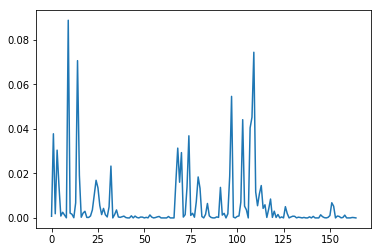

In [40]:
#Chose best estimator 
#RFbest = grid_search.best_estimator_
#or chose and train another one
RFbest = RandomForestClassifier(n_estimators=50)
RFbest.fit(Feature_train,mat_encod_train)

print(confusion_matrix(RFbest.predict(Feature_test), mat_encod_test))
print(np.mean(RFbest.predict(Feature_test) == mat_encod_test))
print(plt.plot(RFbest.feature_importances_))
A = RFbest.predict(Feature_test) == mat_encod_test
print(np.shape(A.reshape((len(A),1))))
print(np.shape(RFbest.predict_proba(Feature_test)))
#print(np.concatenate([RFbest.predict_proba(Feature_test),A.reshape((len(A),1)),mat_test.reshape((len(mat_test),1))],axis=1))

B = RFbest.predict(Feat) == material_cat_encoded
C = np.concatenate([RFbest.predict_proba(Feat),B.reshape((len(B),1)),outputs["material"].reshape((len(outputs["material"]),1))],\
                   axis=1)
D = np.argwhere(C[:,2] == False)
print(D)
#print(np.concatenate([RFbest.predict_proba(Feat),B.reshape((len(B),1)),outputs["material"].reshape((len(outputs["material"]),1))],axis=1))
#print (np.concatenate([RFbest.predict(Feat),outputs["material"]],axis=1))
#for i in range(0,40):
#    print( RFbest.predict(Feat)[i], "  ", outputs["material"][i])

In [72]:
# indices that were misclassified in some cases:
# 134 : proba 0.53 - 0.47
# 339 : proba 0.53 - 0.47 (several times)
# 381 : proba 0.25 - 0.75 (11)
print(C[339,:])
print(C[381,:])

[0.235 0.765 True 'Clash']
[0.29 0.71 False 'Benth']


### 3.2 Select a model and train it on the whole input data

In [232]:
#Chose the model parameters (from the above experiments or in another way)
nb_estim = 100

RFclassif = RandomForestClassifier(n_estimators=nb_estim)
RFclassif.fit(Feat,material_cat_encoded)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Save the classification model

In [233]:
joblib.dump(RFclassif, CHALLENGE_PATH + "ModelClassif.pkl")

['C:/Chazal/ChallengeIFPEN2018/ModelClassif.pkl']

## 4. Regression on sor, splitting the data into 2 parts to consider material separately

In [124]:
#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hZ_pers,\
#                       Feat_SetIntensity2_pers],axis=1)

#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,\
#                       Feat_bd,Feat_ent_DTM1, Feat_ent_Intensity2,Feat_ent_locmax_dist],axis=1)

#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hZ_pers,\
#                       Feat_SetIntensity2_pers,Feat_bd,Feat_skel_pers],axis=1)

Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_SetIntensity2_pers],axis=1)

print(np.shape(Feat))

(400, 112)


### 4.1 Splitting data into train/test to experiments

In [125]:
Feature_train, Feature_test, y_train, y_test, mat_train, mat_test, mat_encod_train, mat_encod_test, outputs_train, outputs_test\
= train_test_split(Feat, outputs["sor"], outputs["material"], material_cat_encoded, outputs, test_size = 0.2)

#### If variable selection 

In [126]:
#Variable selection according to variance threshold
sel = VarianceThreshold(threshold=(.99 * (1 - .99)))
Feature_train = sel.fit_transform(Feature_train)

#sel = SelectKBest(f_regression, k=232)
#Feature_train = sel.fit_transform(Feature_train,y_train)

print(np.shape(Feature_train))
mask = sel.get_support()
Feature_test = Feature_test[:,mask]

(320, 79)


In [127]:
Fdim = np.shape(Feat)[1]

Tag_train0 = mat_encod_train == 0 
Wtrain0 = np.argwhere(Tag_train0)
X_train0 = Feature_train[Tag_train0]
y_train0 = y_train[Tag_train0]

Tag_test0 = mat_encod_test == 0
Wtest0 = np.argwhere(Tag_test0)
X_test0 = Feature_test[Tag_test0]
y_test0 = y_test[Tag_test0]

Tag_train1 = mat_encod_train == 1
Wtrain1 = np.argwhere(Tag_train1)
X_train1 = Feature_train[Tag_train1]
y_train1 = y_train[Tag_train1]

Tag_test1 = mat_encod_test == 1
Wtest1 = np.argwhere(Tag_test1)
X_test1 = Feature_test[Tag_test1]
y_test1 = y_test[Tag_test1]

#### Regression on class 0 (with scaling)

In [128]:
###### Class 0  ####
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train0)
X_train0 = scaler.transform(X_train0)

param_grid = [{'n_estimators': [30, 40, 50, 70, 100, 200, 250], 'learning_rate': [0.04, 0.06, 0.07, 0.1, 0.12, 0.16] }]
#RF = GradientBoostingRegressor()
RF = xgb.XGBRegressor()
grid_search = GridSearchCV(RF, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train0, y_train0)

print("Best parameters:  ", grid_search.best_params_)

X_test0 = scaler.transform(X_test0)

RFbest0 = grid_search.best_estimator_

Best parameters:   {'learning_rate': 0.12, 'n_estimators': 30}


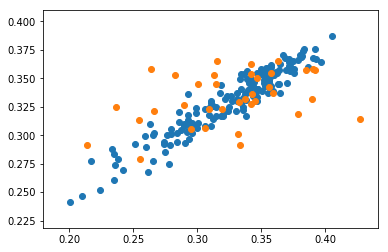

In [129]:
plt.scatter(y_train0,RFbest0.predict(X_train0))
plt.scatter(y_test0,RFbest0.predict(X_test0))

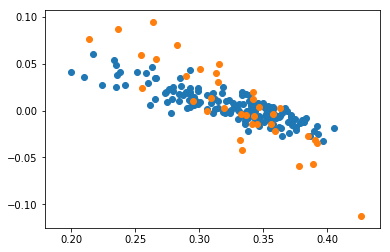

In [130]:
plt.scatter(y_train0,RFbest0.predict(X_train0)-y_train0)
plt.scatter(y_test0,RFbest0.predict(X_test0)-y_test0)

In [131]:
###### Class 1  ####
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train1)
X_train1 = scaler.transform(X_train1)

param_grid = [{'n_estimators': [30, 40, 50, 70, 100, 200, 250], 'learning_rate': [0.04, 0.06, 0.07, 0.1, 0.12, 0.16] }]
#RF = GradientBoostingRegressor()
RF = xgb.XGBRegressor()
grid_search = GridSearchCV(RF, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train1, y_train1)

print("Best parameters:  ", grid_search.best_params_)

X_test1 = scaler.transform(X_test1)
RFbest1 = grid_search.best_estimator_

Best parameters:   {'learning_rate': 0.16, 'n_estimators': 40}


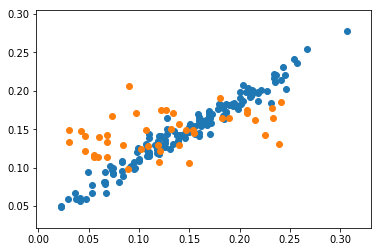

In [132]:
plt.scatter(y_train1,RFbest1.predict(X_train1))
plt.scatter(y_test1,RFbest1.predict(X_test1))

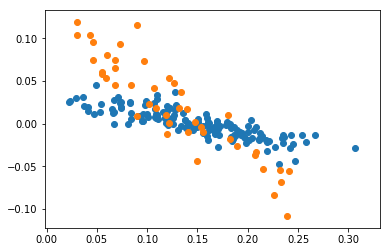

In [133]:
plt.scatter(y_train1,RFbest1.predict(X_train1)-y_train1)
plt.scatter(y_test1,RFbest1.predict(X_test1)-y_test1)

### 4.2 Training the two models on the whole input data splitted in two classes

In [207]:
#Scale the data
scaler = MinMaxScaler()
scaler.fit(Feat)
Feat_scaled = scaler.transform(Feat)

In [208]:
Fdim = np.shape(Feat)[1]

#y = outputs["sor"].values.reshape(NB_INPUT_IMG,1)
y = outputs["sor"]

Tag0 = material_cat_encoded == 0 
W0 = np.argwhere(Tag0)
X0 = Feat_scaled[Tag0]
y0 = y[Tag0]


Tag1 = material_cat_encoded == 1
W1 = np.argwhere(Tag1)
X1 = Feat_scaled[Tag1]
y1 = y[Tag1]

In [209]:
###### Class 0  ####

param_grid = [{'n_estimators': [30, 40, 50, 70, 100, 200, 250], 'learning_rate': [0.04, 0.06, 0.07, 0.1, 0.12, 0.16] }]
RF = GradientBoostingRegressor()
grid_search = GridSearchCV(RF, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X0, y0)

print("Best parameters:  ", grid_search.best_params_)

RFbest0 = grid_search.best_estimator_

Best parameters:   {'learning_rate': 0.07, 'n_estimators': 200}


In [210]:
###### Class 1  ####

param_grid = [{'n_estimators': [30, 40, 50, 70, 100, 200, 250], 'learning_rate': [0.04, 0.06, 0.07, 0.1, 0.12, 0.16] }]
RF = GradientBoostingRegressor()
grid_search = GridSearchCV(RF, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X1, y1)

print("Best parameters:  ", grid_search.best_params_)

RFbest1 = grid_search.best_estimator_

Best parameters:   {'learning_rate': 0.06, 'n_estimators': 200}


In [211]:
#To save the best model 
joblib.dump(scaler,CHALLENGE_PATH + "scalerSor.pkl")
joblib.dump(RFbest0, CHALLENGE_PATH + "modelSor0.pkl")
joblib.dump(RFbest1, CHALLENGE_PATH + "modelSor1.pkl")

['C:/Chazal/ChallengeIFPEN2018/modelSor1.pkl']

## 4bis. Regression on sor without splitting the data

In [41]:
#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hZ_pers,\
#                       Feat_SetIntensity2_pers,Feat_locmax_dist_pers,Feat_bd,Feat_ent],axis=1)

#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_SetIntensity2_pers,Feat_locmax_dist_pers],axis=1)

#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_SetIntensity2_pers],axis=1)
#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density],axis=1)

#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_SetIntensity2_pers,Feat_bd],axis=1)

#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_bd,Feat_ent],axis=1)

#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_bd,Feat_SetIntensity2_pers],axis=1)

Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
                       Feat_SetIntensity2_pers,Feat_bd,Feat_skel_pers],axis=1)


print(np.shape(Feat))

(400, 463)


### If one wants to first do variable selection

In [42]:
#Variable selection according to variance threshold
sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
Feat = sel.fit_transform(Feat)
print(np.shape(Feat))

(400, 236)


### If one wants to do a PCA

In [779]:
scaler = MinMaxScaler()
scaler.fit(Feat)
Feat = scaler.transform(Feat)

pca = PCA(n_components=60)
Feat = pca.fit_transform(Feat)
print(np.shape(Feat))
print(pca.explained_variance_)
print("-------")
print(pca.explained_variance_ratio_)
print("-------")
print(np.sum(pca.explained_variance_ratio_))
print("-------")
print(pca.singular_values_)

#Feat = np.concatenate([Feat_mat,Feat],axis=1)

(400, 60)
[3.51411636 1.91899935 0.92381103 0.54029995 0.4642601  0.38560164
 0.32532702 0.26104963 0.22665766 0.16012416 0.14281352 0.11478694
 0.100626   0.09725853 0.08799703 0.0830439  0.07132144 0.06933056
 0.05890305 0.05659682 0.052715   0.04665261 0.0452123  0.04210321
 0.04191328 0.03938987 0.03834935 0.03627021 0.03442456 0.0327032
 0.03079965 0.02997835 0.02894062 0.02821358 0.02607502 0.02506681
 0.02448481 0.02300502 0.02285882 0.02185553 0.02072157 0.02013493
 0.01949832 0.018899   0.01840903 0.01814588 0.01809286 0.01746309
 0.01698657 0.01661011 0.01566489 0.01514044 0.01448225 0.01401591
 0.01347472 0.01330399 0.01299052 0.01249355 0.01239985 0.01204729]
-------
[0.32070579 0.175132   0.08430898 0.04930893 0.04236937 0.03519083
 0.02969004 0.02382395 0.02068526 0.01461327 0.01303347 0.0104757
 0.00918334 0.00887602 0.0080308  0.00757876 0.00650895 0.00632726
 0.00537562 0.00516515 0.00481088 0.00425762 0.00412617 0.00384243
 0.0038251  0.0035948  0.00349984 0.0033101  

In [43]:
Feature_train, Feature_test, y_train, y_test, mat_train, mat_test, mat_encod_train, mat_encod_test, outputs_train, outputs_test\
= train_test_split(Feat, outputs["sor"], outputs["material"], material_cat_encoded, outputs, test_size = 0.2)

In [44]:
#scaler = StandardScale#r()
scaler = MinMaxScaler()
scaler.fit(Feature_train)
X = scaler.transform(Feature_train)


#param_grid = [{'n_estimators': [30, 40, 50, 70, 100, 200, 250], 'learning_rate': [0.05, 0.07, 0.1, 0.12, 0.14] }]
param_grid = [{'n_estimators': [30, 40, 50, 60, 80, 100, 150], 'learning_rate': [0.04, 0.06, 0.07, 0.1, 0.12] ,\
               'max_depth': [3, 4], 'booster': ["gbtree", "dart"]}]

#RF = GradientBoostingRegressor()
RF = xgb.XGBRegressor()
grid_search = GridSearchCV(RF, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True)

#grid_search = GridSearchCV(RF, param_grid, cv=4,
#                           scoring='neg_mean_absolute_error', return_train_score=True)



grid_search.fit(X, y_train)


print("Best parameters:  ", grid_search.best_params_)

X_train = X
X_test = scaler.transform(Feature_test)

Best parameters:   {'booster': 'dart', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 150}


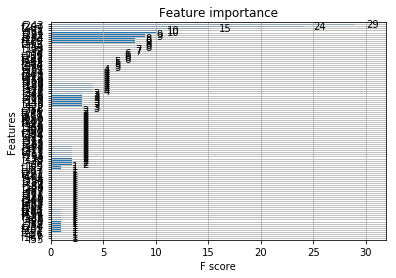

In [589]:
xgb.plot_importance(grid_search.best_estimator_)

In [45]:
#To plot all the scores from grid search
cvres = grid_search.cv_results_
for sc1, sc2, sc3 in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    print("Test: ", -sc1, " - Train: ", -sc2, "  ", sc3)

Test:  0.010136736917250913  - Train:  0.008883276314777571    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 30}
Test:  0.0060999771701881695  - Train:  0.004680326230481903    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 40}
Test:  0.004244274714251301  - Train:  0.002670178931455669    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 50}
Test:  0.003370241373149281  - Train:  0.0016629674663402453    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 60}
Test:  0.0028186737641873296  - Train:  0.0008272367375858553    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 80}
Test:  0.0026841338635105916  - Train:  0.0005385246620995797    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 100}
Test:  0.0026149927734680626  - Train:  0.00025949584005050344    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n

#### Some plots to see the results on test set

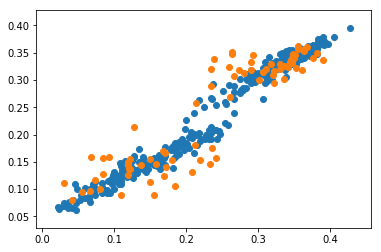

In [46]:
RFbest = grid_search.best_estimator_
plt.scatter(y_train,RFbest.predict(X_train))
plt.scatter(y_test,RFbest.predict(X_test))

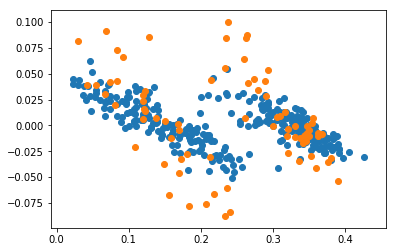

In [47]:
plt.scatter(y_train,RFbest.predict(X_train)-y_train)
plt.scatter(y_test,RFbest.predict(X_test)-y_test)

#### Train the model on the whole input data

In [212]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(Feat)
X = scaler.transform(Feat)
print(np.shape(X))

#Feature selection
#sel = SelectKBest(f_regression, k=240)
#X_train_scaled = sel.fit_transform(X_train_scaled,y_train)
sel = VarianceThreshold(threshold=(.98 * (1 - .98)))
X = sel.fit_transform(X)
mask = sel.get_support()
print("nb features: ", np.shape(X))


#param_grid = [{'n_estimators': [10, 30, 40, 70, 100, 200, 250, 350, 450, 600],\
#               'learning_rate': [0.03, 0.05, 0.07, 0.1, 0.12, 0.14] }]
param_grid = [{'n_estimators': [30, 40, 50, 60, 80, 100, 150, 200, 250], 'learning_rate': [0.04, 0.06, 0.07, 0.1, 0.12, 0.14] ,\
               'max_depth': [3, 4], 'booster': ["gbtree", "gblinear", "dart"]}]
#RF = GradientBoostingRegressor()
RF = xgb.XGBRegressor()
grid_search = GridSearchCV(RF, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True)

#grid_search = GridSearchCV(RF, param_grid, cv=4,
#                           scoring='neg_mean_absolute_error', return_train_score=True)



grid_search.fit(X, outputs["sor"])


print("Best parameters:  ", grid_search.best_params_)
print("Best score:  ", grid_search.best_score_)

(400, 332)
nb features:  (400, 193)
Best parameters:   {'booster': 'dart', 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 100}
Best score:   -0.0024373675274176176


In [214]:
#To save the best model 
pickle.dump(mask,open(CHALLENGE_PATH + "maskSor.dat", "wb"))
joblib.dump(scaler,CHALLENGE_PATH + "scalerSor.pkl")
joblib.dump(grid_search.best_estimator_, CHALLENGE_PATH + "modelSorBis.pkl")

['C:/Chazal/ChallengeIFPEN2018/modelSorBis.pkl']

## 5. Regression on the sum of bins

In [217]:
###Warning Classif_pred is added as a new feature!
Feat_bin = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
                       Feat_SetIntensity2_pers,Feat_bd,Feat_skel],axis=1)

#Feat_bin = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hZ_pers,\
#                       Feat_SetIntensity2_pers],axis=1)

#Feat_bin = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_bd,Feat_ent_Intensity2,Feat_ent_locmax_dist],axis=1)

In [218]:
scaler = MinMaxScaler()
scaler.fit(Feat_bin)
X_bin = scaler.transform(Feat_bin)

b_sum = np.zeros((np.shape(X_bin)[0],1))

for idx in range(12):
    bin = "bin " + str(idx+1)
    b_sum = b_sum + outputs[bin].values.reshape(np.shape(b_sum))
    
#param_grid = [{'n_neighbors':[1,2,3,4,5,8,10,12,15,16,17,18,19,20,25], 'weights':['uniform', 'distance']}]
#RF_bin = KNeighborsRegressor()

param_grid = [{'n_estimators':[30,50,70,100,150,200], 'learning_rate': [0.04, 0.06, 0.07, 0.1, 0.12, 0.14],\
              'booster': ["gbtree", "gblinear", "dart"]}]
RF_bin = xgb.XGBRegressor()

grid_search = GridSearchCV(RF_bin, param_grid, cv=4, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_bin,b_sum)
print("Best parameters:  ", grid_search.best_params_)
bin_best = grid_search.best_estimator_

Best parameters:   {'booster': 'dart', 'learning_rate': 0.04, 'n_estimators': 200}


In [219]:
#To save the best model 
joblib.dump(scaler,CHALLENGE_PATH + "scalerBins.pkl")
joblib.dump(bin_best, CHALLENGE_PATH + "modelBins.pkl")

['C:/Chazal/ChallengeIFPEN2018/modelBins.pkl']

## ---------------------------------------------------------------------

## 6. Computing the IFPEN challenge score

### 6.1 IFPEN functions to compute score

In [48]:
def compute_q2(y_true, y_pred):

    if y_true.shape[0] != y_pred.shape[0]:
        sys.exit("Error : number of elements in prediction not equal to number of elements in test")
    elif y_true.shape[1] != y_pred.shape[1]:
        sys.exit("Error : number of features in prediction not equal to number of features in test")

    y_mean = compute_ymean(y_true)

    score_data = compute_score(y_true, y_pred, 10, 0.01)

    score_mean = compute_score(y_true, y_mean, 10, 0.01)

    return 1 - sum(score_data)/sum(score_mean)


def compute_ymean(y_true):
    row_y_mean = np.mean(y_true, 0)
    return np.tile(row_y_mean, (np.size(y_true, 0), 1))


def compute_score(y_true, y_pred, scaling_sor, scaling_bins):
    score_material = (y_true[:, 0] - y_pred[:, 0])**2

    sor_mean_true = np.mean(y_true[:, 1])

    score_sor = ((y_true[:, 1] - y_pred[:, 1])/sor_mean_true)**2
    row_bin_mean_true = np.mean(y_true[:, 2:14], 1)
    #print(np.shape(row_bin_mean_true))
    row_bin_mean_pred = np.mean(y_pred[:, 2:14], 1)
    bin_mean_true = np.mean(row_bin_mean_true)
    score_bins = ((row_bin_mean_true-row_bin_mean_pred)/bin_mean_true)**2
    #print(np.shape(score_bins))
    #return score_material + scaling_sor * score_sor + scaling_bins * score_bins
    return score_material + scaling_sor * score_sor + scaling_bins * score_bins

### 6.2 Split data and create output on the test part 

In [438]:
#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_skel_pers,Feat_SetIntensity2_pers],axis=1)

Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hZ_pers,\
                       Feat_SetIntensity2_pers,Feat_bd,Feat_skel_pers],axis=1)

#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,Feat_hX_pers,Feat_hZ_pers,\
#                       Feat_SetIntensity2_pers,Feat_bd,Feat_skel_pers,Feat_ent],axis=1)

#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,\
#                       Feat_bd,Feat_skel],axis=1)

#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_SetIntensity2_pers,Feat_locmax_dist_pers],axis=1)

#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density],axis=1)

#Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_SetIntensity2_pers,Feat_bd,Feat_ent],axis=1)

#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_DTM1_pers,\
#                       Feat_bd,Feat_ent_Intensity2,Feat_ent_locmax_dist],axis=1)

#Feat = np.concatenate([Feat_Voids,Feat_loc_max,Feat_density,Feat_bd],axis=1)


print(np.shape(Feat))


Feature_train, Feature_test, y_train, y_test, mat_train, mat_test, mat_encod_train, mat_encod_test, outputs_train, outputs_test\
= train_test_split(Feat, outputs["sor"], outputs["material"], material_cat_encoded, outputs, test_size = 0.2)

(400, 679)


#### If variable selection

In [290]:
sel0 = VarianceThreshold(threshold=0.005)
Feature_train = sel0.fit_transform(Feature_train)
mask0 = sel0.get_support()
Feature_test = Feature_test[:,mask0]
print(np.shape(Feature_train))

scaler0 = MinMaxScaler()
scaler0.fit(Feature_train)
Feature_train = scaler0.transform(Feature_train)
Feature_test = scaler0.transform(Feature_test)

#Variable selection according to variance threshold
sel = VarianceThreshold(threshold=(0.02))
Feature_train = sel.fit_transform(Feature_train)

#sel = SelectKBest(f_regression, k=232)
#Feature_train = sel.fit_transform(Feature_train,y_train)

print(np.shape(Feature_train))
mask = sel.get_support()
Feature_test = Feature_test[:,mask]

(320, 316)
(320, 168)


(320, 327)
(320, 194)
(80, 194)


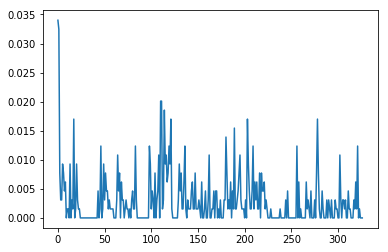

In [439]:
sel0 = VarianceThreshold(threshold=0.001)
Feature_train = sel0.fit_transform(Feature_train)
mask0 = sel0.get_support()
Feature_test = Feature_test[:,mask0]
print(np.shape(Feature_train))

scaler0 = MinMaxScaler()
scaler0.fit(Feature_train)
Feature_train = scaler0.transform(Feature_train)
Feature_test = scaler0.transform(Feature_test)

RFreg = xgb.XGBRegressor()
#RFreg = RandomForestRegressor(n_estimators=100)
RFreg.fit(Feature_train,y_train)
plt.plot(RFreg.feature_importances_)
#print(RFreg.feature_importances_[0:10])
mask = RFreg.feature_importances_ > 0.0015
Feature_train = Feature_train[:,mask]
Feature_test = Feature_test[:,mask]
print(np.shape(Feature_train))
print(np.shape(Feature_test))


In [431]:
sel0 = VarianceThreshold(threshold=0.005)
Feature_train = sel0.fit_transform(Feature_train)
mask0 = sel0.get_support()
Feature_test = Feature_test[:,mask0]
print(np.shape(Feature_train))

scaler0 = MinMaxScaler()
scaler0.fit(Feature_train)
Feature_train = scaler0.transform(Feature_train)
Feature_test = scaler0.transform(Feature_test)

sel = SelectKBest(f_regression, k=70)
Feature_train = sel.fit_transform(Feature_train, y_train)
Feature_test = sel.transform(Feature_test)
print(np.shape(Feature_train))

(320, 180)
(320, 70)


#### Classification

In [440]:
#Compute material prediction 
#Remove Feat_mat here
X_train = Feature_train[:,1:]
X_test = Feature_test[:,1:]

RF = RandomForestClassifier(n_estimators=200)
RF.fit(X_train,mat_encod_train)
mat_pred = RF.predict(X_test)

#print(np.mean(RF.predict(Feature_train) == label_train) )
print(confusion_matrix(RF.predict(X_test), mat_encod_test))
#print(np.shape(mat_pred))
#print(mat_pred)

[[36  2]
 [ 0 42]]


#### Regression on sor

In [ ]:
X_train = Feature_train
X_test = Feature_test

scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#X_train_scaled = X_train
#X_test_scaled = X_test


#Feature selection
#sel = SelectKBest(f_regression, k=240)
#X_train_scaled = sel.fit_transform(X_train_scaled,y_train)
#sel = VarianceThreshold(threshold=(.95 * (1 - .95)))
#X_train_scaled = sel.fit_transform(X_train_scaled)
#mask = sel.get_support(),

#param_grid = [{'n_estimators': [40, 50, 60, 80, 100, 150, 200, 250], 'learning_rate': [0.04, 0.06, 0.07, 0.1, 0.12] ,\
#               'max_depth': [3, 4], 'booster': ["gbtree", "gblinear", "dart"]}]
param_grid = [{'n_estimators': [50, 80, 100, 150, 200], 'learning_rate': [0.04, 0.06, 0.07, 0.1] ,\
               'max_depth': [3], 'booster': ["gbtree", "gblinear", "dart"]}]
#RF = GradientBoostingRegressor()
RF = xgb.XGBRegressor()
grid_search = GridSearchCV(RF, param_grid, cv=4,
                           scoring='neg_mean_squared_error', return_train_score=True)

#grid_search = GridSearchCV(RF, param_grid, cv=4,
#                           scoring='neg_mean_absolute_error', return_train_score=True)



grid_search.fit(X_train_scaled, y_train)

RFsor = grid_search.best_estimator_

print("Best parameters:  ", grid_search.best_params_)

y_sor = grid_search.best_estimator_.predict(X_test_scaled)

#### Linear regression on sor

Train:
0.8562717551031387
0.03962064971381553
Test:
0.786430759921609
0.05135351032682807


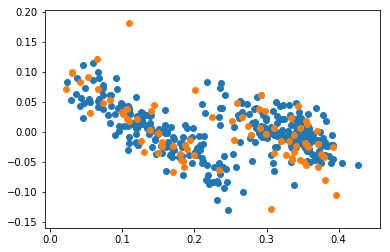

In [331]:
X_train = Feature_train
X_test = Feature_test

scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LinearRegression()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print('Train:')
print(met.r2_score(y_train, clf.predict(X_train_scaled)))
print(np.sqrt(met.mean_squared_error(y_train, clf.predict(X_train_scaled))))
print('Test:')
print(met.r2_score(y_test, y_pred))
print(np.sqrt(met.mean_squared_error(y_test, y_pred)))

plt.scatter(y_train,clf.predict(X_train_scaled)-y_train)
plt.scatter(y_test,clf.predict(X_test_scaled)-y_test)

y_sor = y_pred

Test:  0.004104267333984252  - Train:  0.0026192099101794092    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 50}
Test:  0.0027717041423804163  - Train:  0.0008461937849017543    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 80}
Test:  0.0026816480734678082  - Train:  0.0005576560058767762    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 100}
Test:  0.002678807575108904  - Train:  0.00030364873532155457    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 150}
Test:  0.002723432318103436  - Train:  0.0001853350698513944    {'booster': 'gbtree', 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 200}
Test:  0.002843208189775283  - Train:  0.00095877465694341    {'booster': 'gbtree', 'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 50}
Test:  0.002683277764867446  - Train:  0.000424185481683709    {'booster': 'gbtree', 'learning_rate': 0.06, 'max_depth': 3, 'n

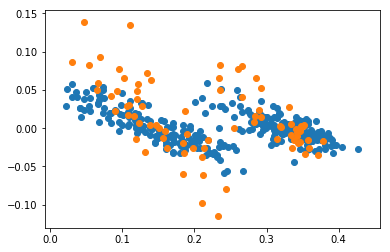

In [434]:
cvres = grid_search.cv_results_
for sc1, sc2, sc3 in zip(cvres["mean_test_score"], cvres["mean_train_score"], cvres["params"]):
    print("Test: ", -sc1, " - Train: ", -sc2, "  ", sc3)
    
RFbest = grid_search.best_estimator_
plt.scatter(y_train,RFbest.predict(X_train_scaled)-y_train)
plt.scatter(y_test,RFbest.predict(X_test_scaled)-y_test)

#### Regression on the sum of bins

In [435]:
scaler = MinMaxScaler()
scaler.fit(Feature_train)
X_train_bin = scaler.transform(Feature_train)
X_test_bin = scaler.transform(Feature_test)

bin_pred = np.zeros((np.shape(X_test_bin)[0],12))
b_sum_train = np.zeros((np.shape(X_train_bin)[0],1))
b_sum_test = np.zeros((np.shape(X_test_bin)[0],1))
for idx in range(12):
    bin = "bin " + str(idx+1)
    b_sum_train = b_sum_train + outputs_train[bin].values.reshape(np.shape(b_sum_train))
    b_sum_test = b_sum_test + outputs_test[bin].values.reshape(np.shape(b_sum_test))
    
param_grid = [{'n_neighbors':[1,2,3,4,5,8,10,12,15,16,17,18,19,20,25], 'weights':['uniform', 'distance']}]
RF_bin = KNeighborsRegressor()

#param_grid = [{'n_estimators':[30,50,70,100,150,200], 'learning_rate': [0.04, 0.06, 0.07, 0.1, 0.12, 0.14]}]
#RF_bin = xgb.XGBRegressor()

grid_search = GridSearchCV(RF_bin, param_grid, cv=4, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_bin,b_sum_train)
print("Best parameters:  ", grid_search.best_params_)
RF_bin_best = grid_search.best_estimator_

print("Test: ", RF_bin_best.score(X_test_bin,b_sum_test), "  Train: ",  RF_bin_best.score(X_train_bin,b_sum_train))

pred = np.ravel(RF_bin_best.predict(X_test_bin))
for idx in range(12):
    bin_pred[:,idx] = pred /12

Best parameters:   {'n_neighbors': 12, 'weights': 'distance'}
Test:  0.5964834920429674   Train:  1.0


In [436]:
bin_pred = np.zeros((np.shape(X_test_bin)[0],12))

#### Evaluation of the score on the test set

In [437]:
#Compute prediction output for score (bin pred are set to 0)
y_all_true = np.ones((np.shape(Feature_test)[0],14))
y_all_pred = np.ones((np.shape(Feature_test)[0],14))


y_all_true[:,0] = mat_encod_test
y_all_true[:,1] = y_test

for idx in range(12):
    bin = "bin " + str(idx+1)
    y_all_true[:,idx+2] = outputs_test[bin]

y_all_pred[:,0] = mat_pred
y_all_pred[:,1] = y_sor
#y_all_pred[:,1] = y_test

y_all_pred[:,2:14] = bin_pred
#For the moment, the pred value for the bins is the averaged one on the whole input data.
#for idx in range(12):      
    #bin = "bin " + str(idx+1)    
    #y_all_pred[:,idx+2] = np.tile(np.mean(outputs[bin]),np.shape(y_all_pred)[0])
    #y_all_pred[:,idx+2] = np.tile(0,np.shape(y_all_pred)[0])


scr = compute_q2(y_all_true,y_all_pred)
print(scr)

0.774178916055362
